# [LVV-T2216] Integrated Slew and Tracking Test - Data Analysis

This notebook is used to analyse the data colleted when running the [LVV-T2216] test case during System Spread Integration Tests on Level 3.  
   
**Requirements:**
 - You should have run this test case and record the time stamps on each step.
 
Upon completion, save the notebook and its output as a pdf file to be attached to the test execution in JIRA. 

**Make sure you run this notebook on TTS before running at the summit.**

Please, see the [README] file for the requirements to run this notebook.

[LVV-T2216]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T2216
[README]: https://github.com/lsst-sitcom/notebooks_vandv/blob/develop/README.md

In [1]:
test_case = "LVV-T2216"
test_exec = "LVV-EXXXX"

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

from astropy.time import Time
from matplotlib import pyplot as plt

from lsst.sitcom import vandv

In [3]:
client = vandv.efd.create_efd_client()

exec_info = vandv.ExecutionInfo()
print(exec_info)


Executed by b1quint on 2022-07-26T16:24:37.044.
  Running in pillan03 at tucson



## Slewing without LUT corrections

In theory, the LUT is always being applied to M1M3, M2, and the Hexapods.  
This section considers that the elevation angle used for LUT calculations comes from the inclinometer and is always 90 deg.  
For the hexapods, the compensation mode is disabled. 

In [4]:
# t_start = "2022-07-20 19:18:09.246021""
# t_end = "2022-07-20 19:22:07.383914"

In [5]:
df = await vandv.efd.query_script_message_contains(
    client=client, 
    contains=[test_case, test_exec, "START", "Slewing without LUT"],
    upper_t=Time.now(),
    lower_t=Time("2022-06-01 17:33", scale="utc", format="iso"),
    num=1)

t_start = vandv.efd.time_pd_to_astropy(df.index[0].floor("1s"))
print(t_start, df.iloc[0]["message"])

2022-07-22T21:14:06.000 START - LVV-T2216 LVV-EXXXX Slewing without LUT


In [6]:
df = await vandv.efd.query_script_message_contains(
    client=client, 
    contains=[test_case, test_exec, "END", "Slewing without LUT"],
    upper_t=Time.now(),
    lower_t=Time("2022-06-01 17:33", scale="utc", format="iso"),
    num=1)

t_end = vandv.efd.time_pd_to_astropy(df.index[0].ceil("1s"))
print(t_end, df.iloc[0]["message"])

2022-07-22T21:18:35.000 END - LVV-T2216 LVV-EXXXX Slewing without LUT


In [7]:
print(f"Starting data analysis between\n  {t_start}\n    and\n  {t_end}")

Starting data analysis between
  2022-07-22T21:14:06.000
    and
  2022-07-22T21:18:35.000


### Analyse M1M3 Data

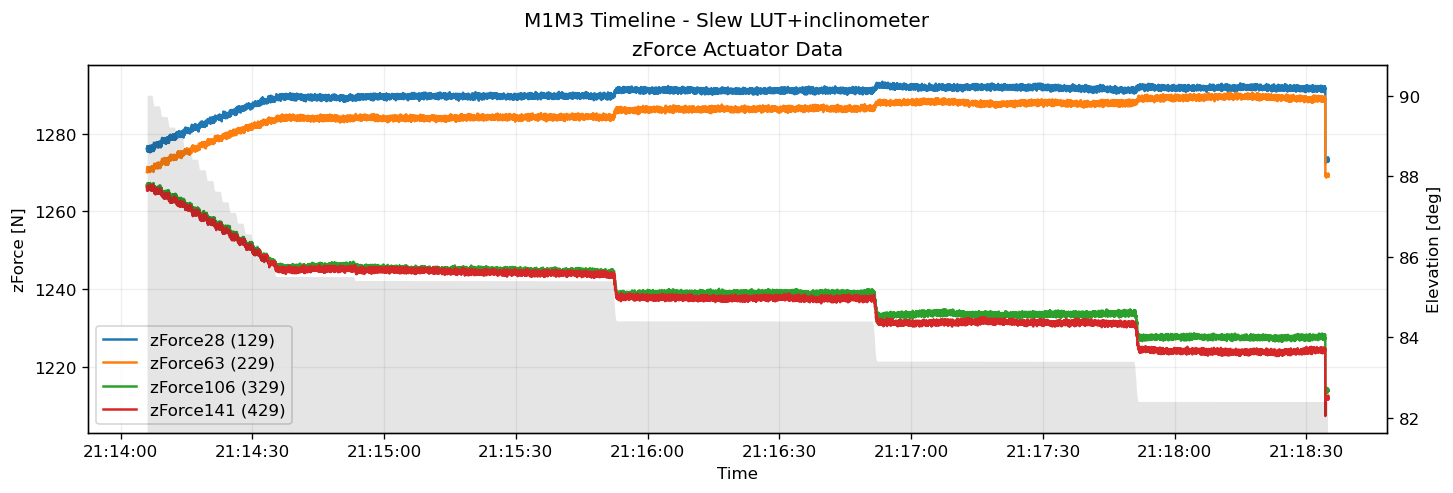

In [8]:
fad = await client.select_time_series(
    "lsst.sal.MTM1M3.forceActuatorData", 
    "*", 
    t_start,
    t_end)

el = await client.select_time_series(
    "lsst.sal.MTMount.elevation",
    "*", 
    t_start,
    t_end)

fig, axs = plt.subplot_mosaic(
    mosaic="A",
    num="Slew Without Correction", 
    constrained_layout=True,
    dpi=120,
    figsize=(12, 4),
)

fig.suptitle("M1M3 Timeline - Slew LUT+inclinometer")
_ = vandv.m1m3.timeline_zforces(axs["A"], fad, "zForce", elevation=el)

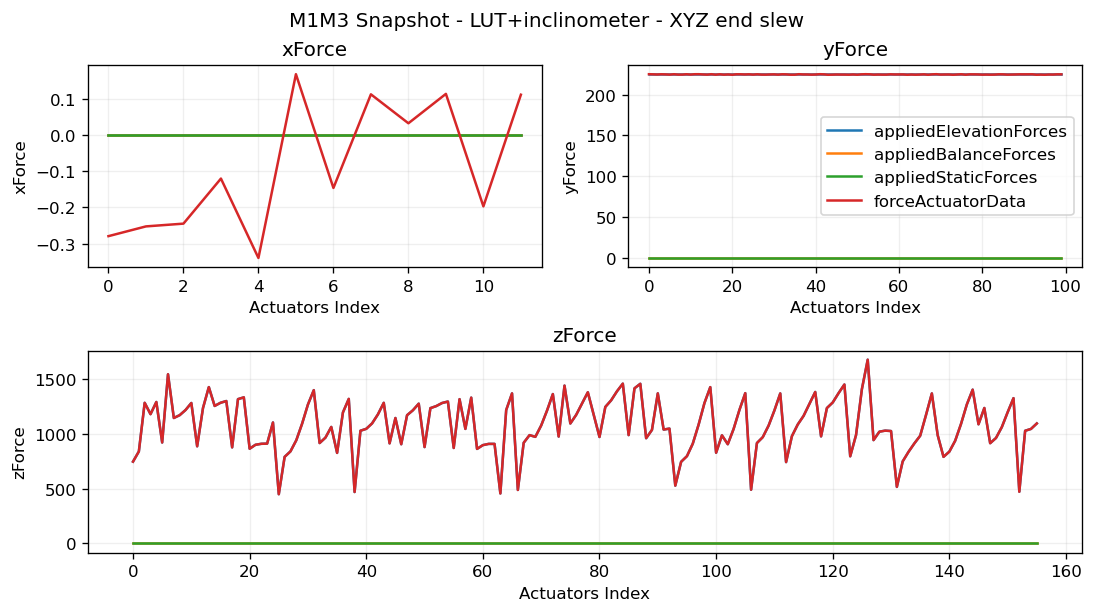

In [9]:
fel = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_appliedElevationForces", 
    "*", 
    t_start,
    t_end)

fba = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_appliedBalanceForces", 
    "*",
    t_start,
    t_end)

fst = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_appliedStaticForces",
    "*",
    t_start,
    t_end)

fao = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_appliedActiveOpticForces",
    "*", 
    t_start,
    t_end)

series = [df.iloc[-1] for df in [fel, fba, fst, fad]]
labels = [
    "appliedElevationForces", 
    "appliedBalanceForces", 
    "appliedStaticForces",
    "forceActuatorData",
]

fig, axs = plt.subplot_mosaic(
    mosaic="AB\nAB\nCC\nCC",
    num="Slew Without Correction - Snapshot Forces", 
    constrained_layout=True,
    dpi=120,
    figsize=(9, 5),
)

fig.suptitle("M1M3 Snapshot - LUT+inclinometer - XYZ end slew")
_ = vandv.m1m3.snapshot_xforces(axs["A"], series)
_ = vandv.m1m3.snapshot_yforces(axs["B"], series, labels=labels)
_ = vandv.m1m3.snapshot_zforces(axs["C"], series)

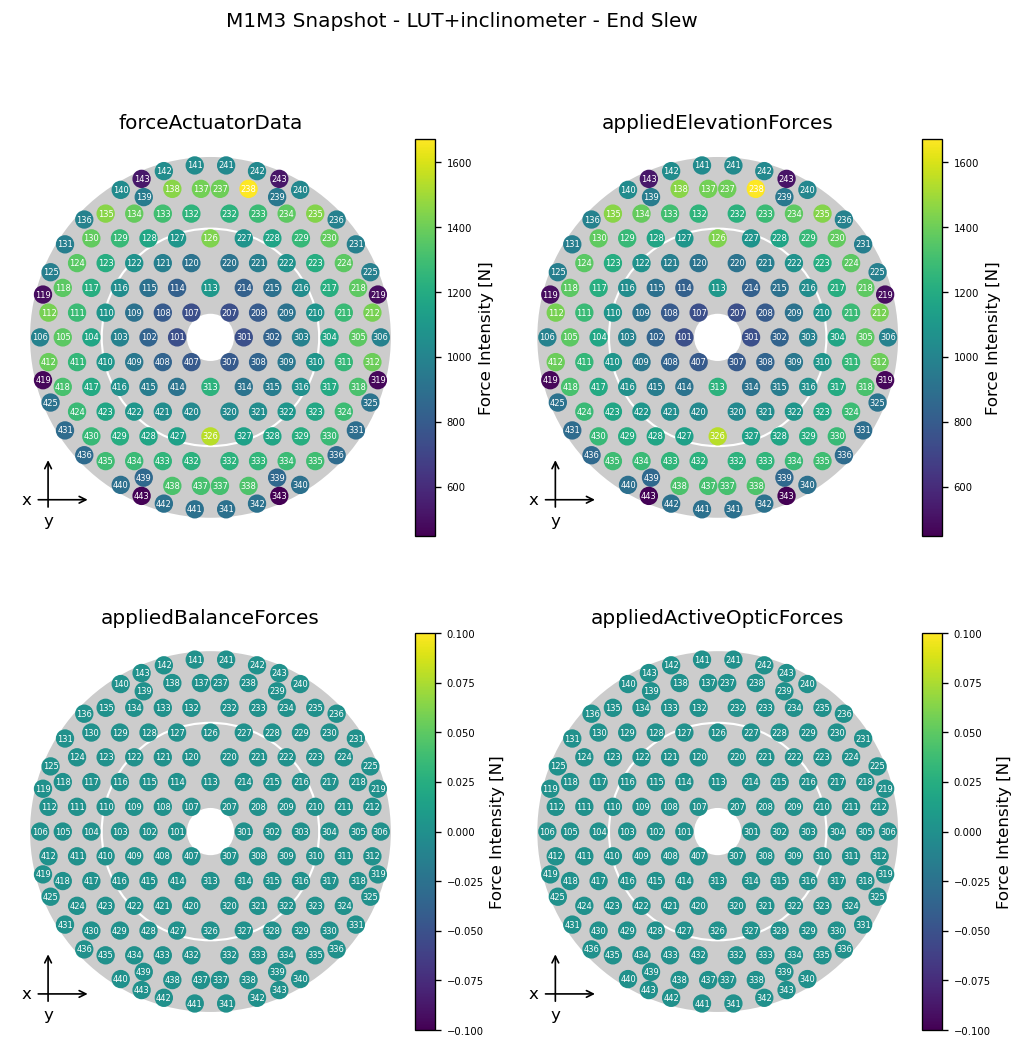

In [10]:
fig, axs = plt.subplot_mosaic(
    mosaic="AB\nCD",
    num="Slew Without Correction - Snapshot zForces Overview", 
    constrained_layout=False,
    dpi=120,
    figsize=(10, 10),
)

fig.suptitle("M1M3 Snapshot - LUT+inclinometer - End Slew")
_ = vandv.m1m3.snapshot_zforces_overview(axs["A"], fad.iloc[-1], title="forceActuatorData")
_ = vandv.m1m3.snapshot_zforces_overview(axs["B"], fel.iloc[-1], title="appliedElevationForces")
_ = vandv.m1m3.snapshot_zforces_overview(axs["C"], fba.iloc[-1], title="appliedBalanceForces")
_ = vandv.m1m3.snapshot_zforces_overview(axs["D"], fao.iloc[-1], title="appliedActiveOpticForces")

### Analyse M2

In [11]:
axf = await client.select_time_series(
    "lsst.sal.MTM2.axialForce", 
    "*",
    t_start,
    t_end)

taf = await client.select_time_series(
    "lsst.sal.MTM2.tangentForce", 
    "*",
    t_start,
    t_end)

cof = await client.select_time_series(
    "lsst.sal.MTM2.command_applyForces",
    "*", 
    t_start,
    t_end)

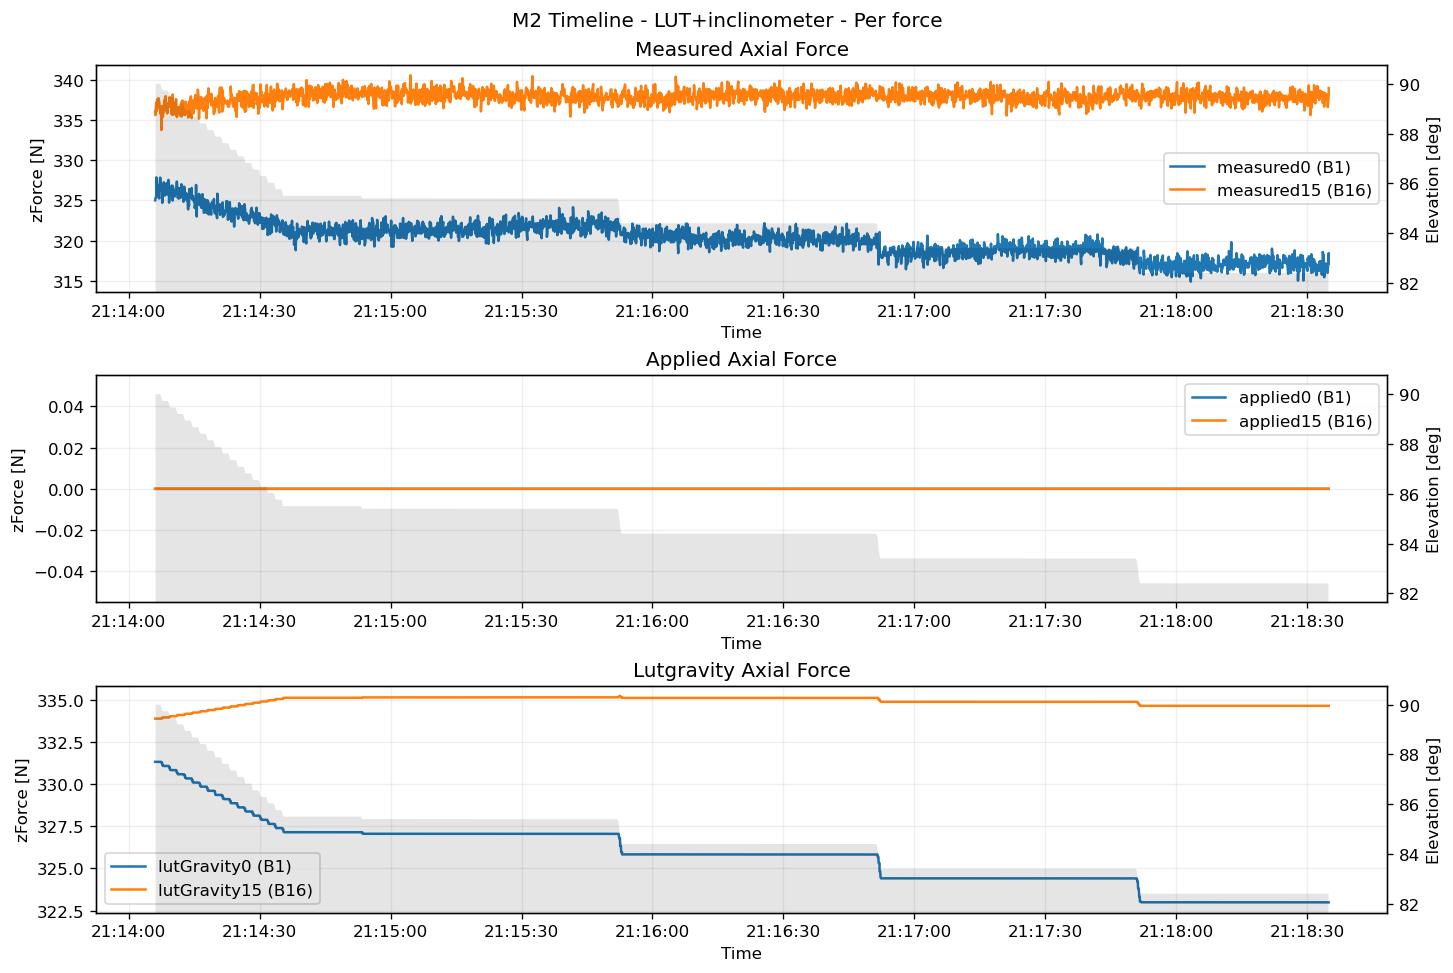

In [12]:
fig, axs = plt.subplot_mosaic(
    mosaic="A\nB\nC",
    num="Slew Without Correction - M2", 
    constrained_layout=True,
    dpi=120,
    figsize=(12, 8),
)

fig.suptitle("M2 Timeline - LUT+inclinometer - Per force")
_ = vandv.m2.timeline_axial_forces(axs["A"], axf, elevation=el)
_ = vandv.m2.timeline_axial_forces(axs["B"], axf, elevation=el, column="applied")
_ = vandv.m2.timeline_axial_forces(axs["C"], axf, elevation=el, column="lutGravity")

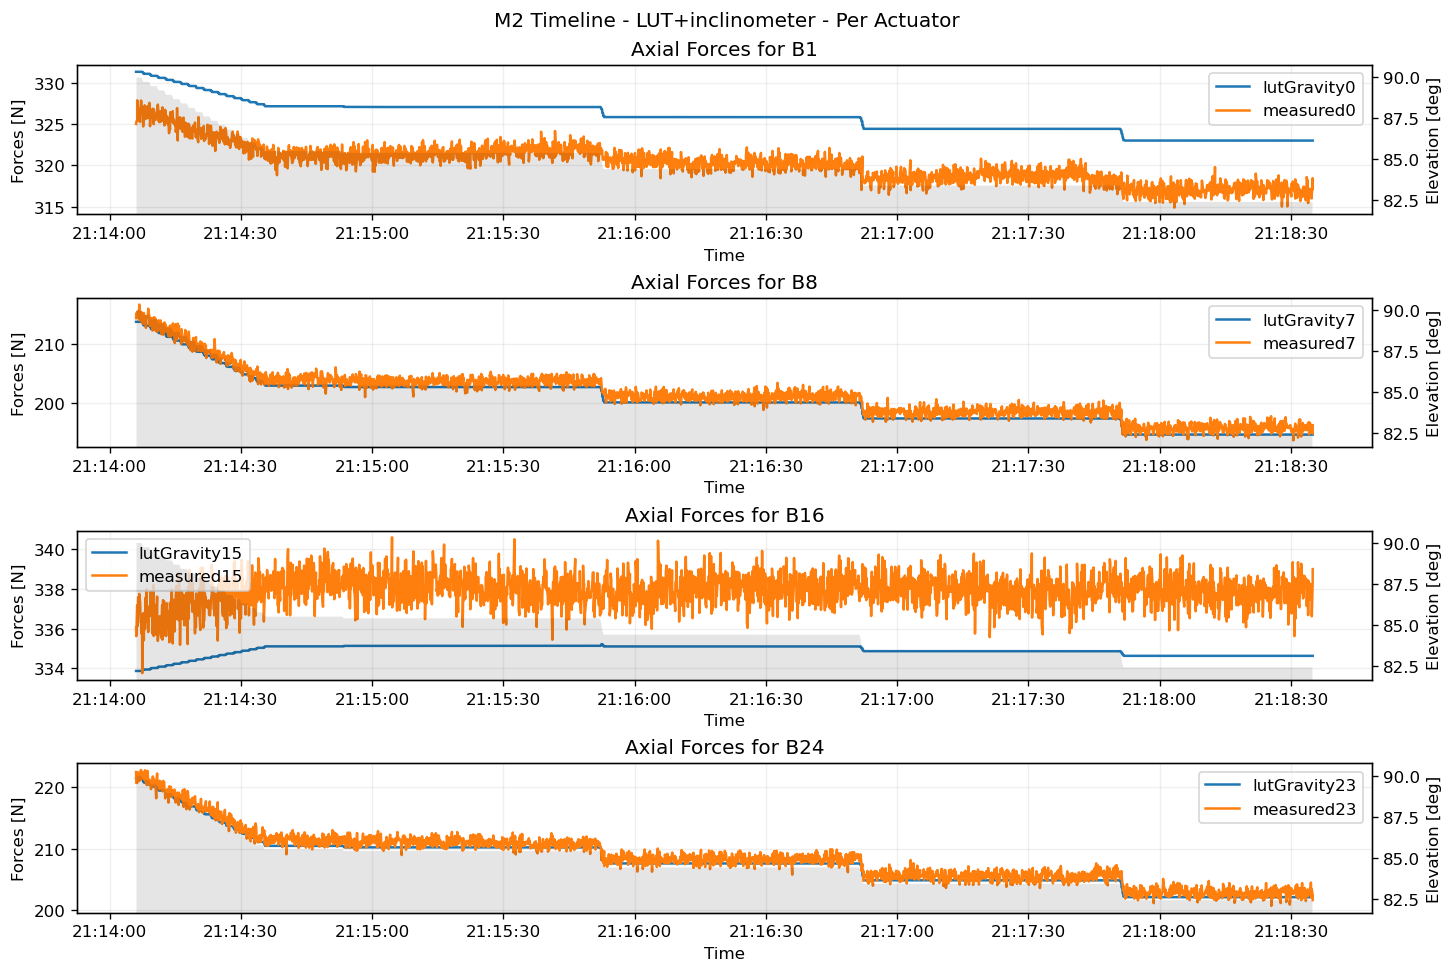

In [13]:
fig, axs = plt.subplot_mosaic(
    mosaic="A\nB\nC\nD",
    num="Slew Without Correction - M2", 
    constrained_layout=True,
    dpi=120,
    figsize=(12, 8),
)

cols = [
    # "applied", 
    # "hardpointCorrection", 
    "lutGravity", 
    # "lutTemperature", 
    "measured"
]

fig.suptitle("M2 Timeline - LUT+inclinometer - Per Actuator")
_ = vandv.m2.timeline_axial_forces_per_act(axs["A"], axf, elevation=el, act="B1", cols=cols)
_ = vandv.m2.timeline_axial_forces_per_act(axs["B"], axf, elevation=el, act="B8", cols=cols)
_ = vandv.m2.timeline_axial_forces_per_act(axs["C"], axf, elevation=el, act="B16", cols=cols)
_ = vandv.m2.timeline_axial_forces_per_act(axs["D"], axf, elevation=el, act="B24", cols=cols)

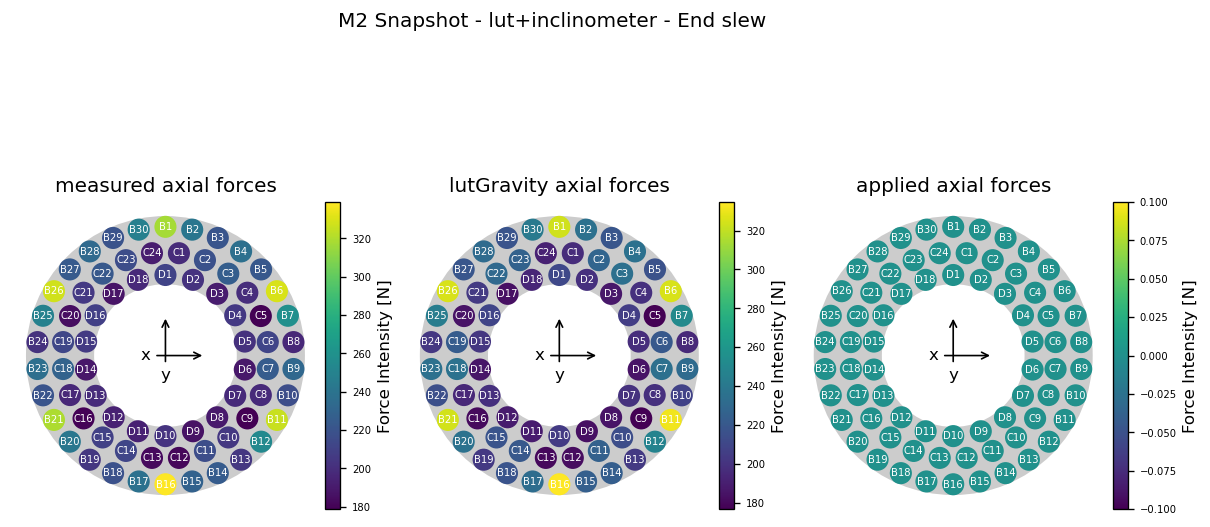

In [15]:
fig, axs = plt.subplot_mosaic(
    mosaic="ABC",
    num="Slew Without Correction - M2 All Actuators", 
    constrained_layout=False,
    dpi=120,
    figsize=(12, 6),
)

fig.suptitle("M2 Snapshot - lut+inclinometer - End slew")
_ = vandv.m2.snapshot_zforces_overview(axs["A"], axf.iloc[-1], ms=150, fs=6)
_ = vandv.m2.snapshot_zforces_overview(axs["B"], axf.iloc[-1], prefix="lutGravity", ms=150, fs=6)
_ = vandv.m2.snapshot_zforces_overview(axs["C"], axf.iloc[-1], prefix="applied", ms=150, fs=6)

### Analyse CamHex

In [16]:
# From the XML:
#   Actual MTHexapod position, in order (X, Y, Z, U, V, W). 
#   Linear positions are in microns, angular positions are in degrees.
pos = await client.select_time_series(
    "lsst.sal.MTHexapod.application",
    "*",
    t_start,
    t_end,
    index=1
)

# Unravel in x/y/z/u/v/w
for i, col in enumerate("xyzuvw"):
    pos[col] = pos[f"position{i}"]


# Triggered at the end of a slew
cpos = await client.select_time_series(
    "lsst.sal.MTHexapod.logevent_compensatedPosition",
    "*",
    t_start,
    t_end,
    index=1
)

# Triggered only after move/offset. Should not see much. 
upos = await client.select_time_series(
    "lsst.sal.MTHexapod.logevent_uncompensatedPosition",
    "*",
    t_start,
    t_end,
    index=1
)

# Estimate the LUT position
lut_pred = vandv.hexapod.get_lut_positions(index=1, elevation=el.actualPosition)
lut = pd.DataFrame(lut_pred, columns=["x", "y", "z", "u", "v", "w"], index=el.index)

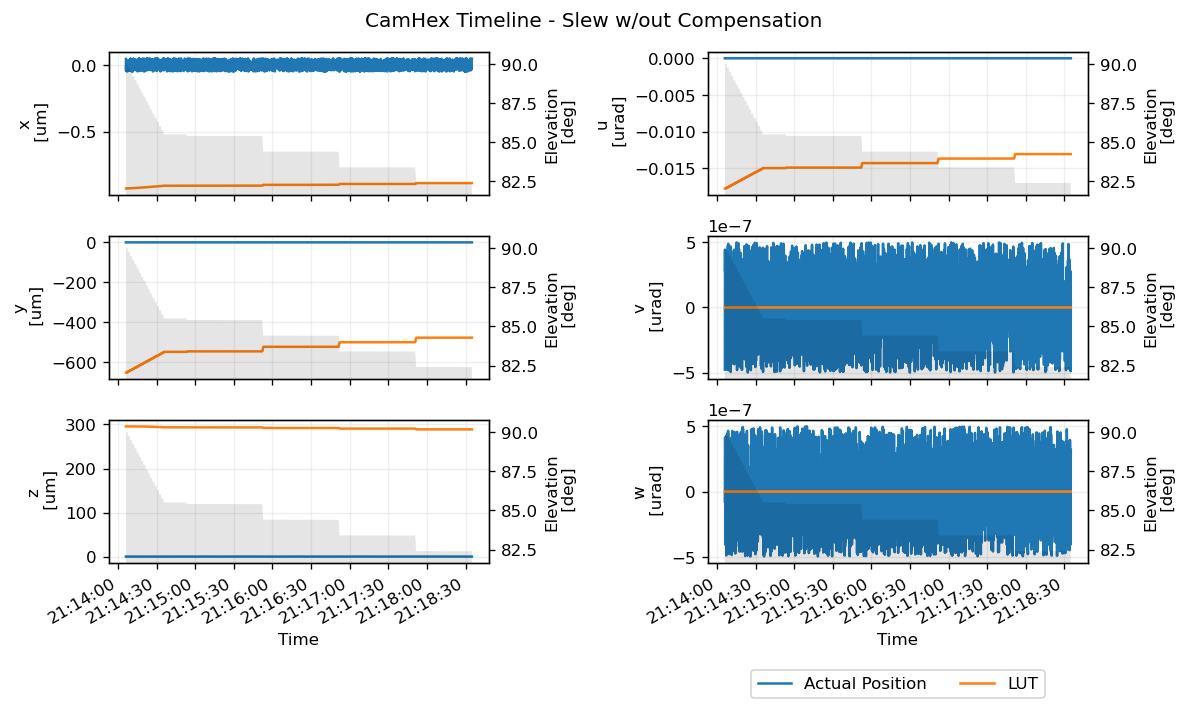

In [17]:
fig, axs = plt.subplot_mosaic(
    mosaic="AD\nBE\nCF",
    num="Slew Without LUT Correction - CamHex Actual Position", 
    dpi=120,
    figsize=(10, 6),
    sharex=True,
)

cols = "xyzuvw"
for ax, col in zip("ABCDEF", cols):
    _ = vandv.hexapod.timeline_position(
        axs[ax], 
        [pos, cpos, upos, lut], 
        column=col, 
        elevation=el, 
        symbols=["", "o", "s", ""],
        names=["Actual Position", "Compensated", "Uncompensated", "LUT"]
    )

# Hide xlabel
for i in "ABDE":
    _ = axs[i].set_xlabel("")
    
_ = axs["F"].legend(loc='lower center', bbox_to_anchor=(0.5, -1), ncol=5)

fig.suptitle("CamHex Timeline - Slew w/out Compensation")
fig.autofmt_xdate()
fig.tight_layout()

### Analyse M2Hex

In [18]:
# From the XML:
#   Actual MTHexapod position, in order (X, Y, Z, U, V, W). 
#   Linear positions are in microns, angular positions are in degrees.
pos = await client.select_time_series(
    "lsst.sal.MTHexapod.application",
    "*",
    t_start,
    t_end,
    index=2
)

# Unravel in x/y/z/u/v/w
for i, col in enumerate("xyzuvw"):
    pos[col] = pos[f"position{i}"]


# Triggered at the end of a slew
cpos = await client.select_time_series(
    "lsst.sal.MTHexapod.logevent_compensatedPosition",
    "*",
    t_start,
    t_end,
    index=2
)

# Triggered only after move/offset. Should not see much. 
upos = await client.select_time_series(
    "lsst.sal.MTHexapod.logevent_uncompensatedPosition",
    "*",
    t_start,
    t_end,
    index=2
)

# Estimate the LUT position
lut_pred = vandv.hexapod.get_lut_positions(index=2, elevation=el.actualPosition)
lut = pd.DataFrame(lut_pred, columns=["x", "y", "z", "u", "v", "w"], index=el.index)

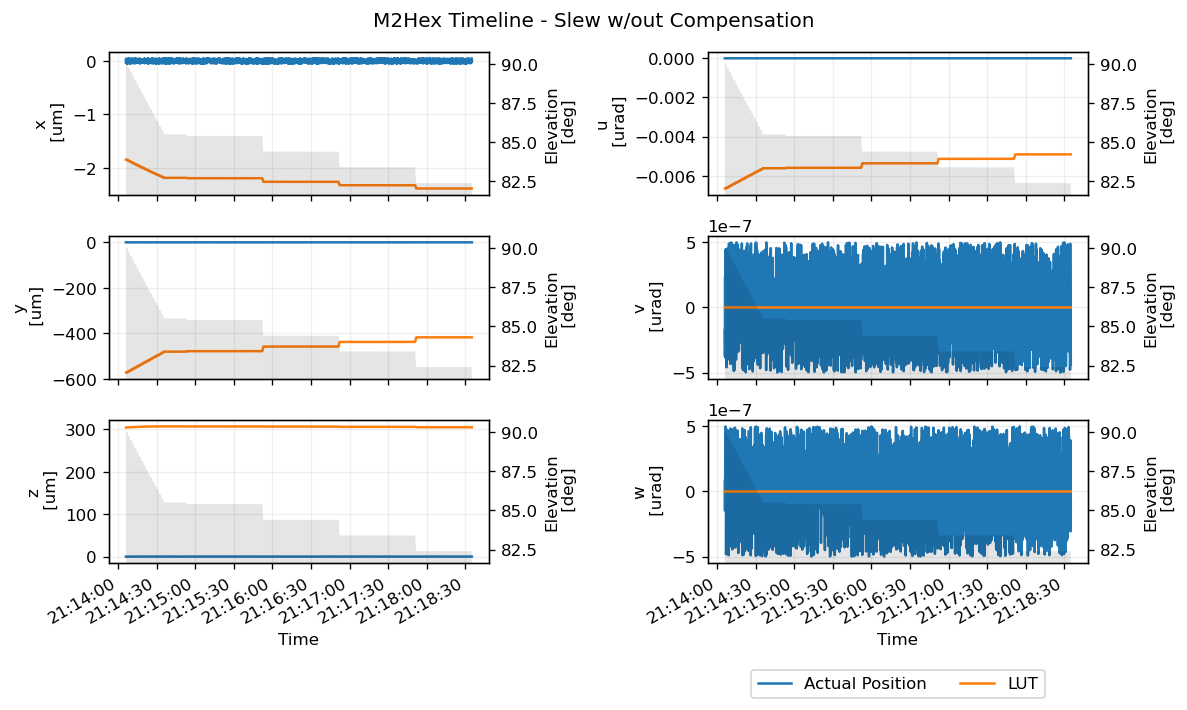

In [19]:
fig, axs = plt.subplot_mosaic(
    mosaic="AD\nBE\nCF",
    num="Slew Without LUT Correction - M2Hex Actual Position", 
    dpi=120,
    figsize=(10, 6),
    sharex=True,
)

cols = "xyzuvw"
for ax, col in zip("ABCDEF", cols):
    _ = vandv.hexapod.timeline_position(
        axs[ax], 
        [pos, cpos, upos, lut], 
        column=col, 
        elevation=el, 
        symbols=["", "o", "s", ""],
        names=["Actual Position", "Compensated", "Uncompensated", "LUT"]
    )

# Hide xlabel
for i in "ABDE":
    _ = axs[i].set_xlabel("")
    
_ = axs["F"].legend(loc='lower center', bbox_to_anchor=(0.5, -1), ncol=5)

fig.suptitle("M2Hex Timeline - Slew w/out Compensation")
fig.autofmt_xdate()
fig.tight_layout()

## Slewing with LUT corrections

In [20]:
t_start = "2022-07-20 19:28:29.149291"
t_end = "2022-07-20 19:32:28.344625"

In [21]:
df = await vandv.efd.query_script_message_contains(
    client=client, 
    contains=[test_case, test_exec, "START", "Slewing with LUT"],
    upper_t=Time.now(),
    lower_t=Time("2022-06-01 17:33", scale="utc", format="iso"),
    num=1)

t_start = vandv.efd.time_pd_to_astropy(df.index[0].floor("1s"))
print(t_start, df.iloc[0]["message"])

2022-07-22T21:23:27.000 START - LVV-T2216 LVV-EXXXX Slewing with LUT


In [22]:
df = await vandv.efd.query_script_message_contains(
    client=client, 
    contains=[test_case, test_exec, "END", "Slewing with LUT"],
    upper_t=Time.now(),
    lower_t=Time("2022-06-01 17:33", scale="utc", format="iso"),
    num=1)

t_end = vandv.efd.time_pd_to_astropy(df.index[0].ceil("1s"))
print(t_end, df.iloc[0]["message"])

2022-07-22T21:27:55.000 END - LVV-T2216 LVV-EXXXX Slewing with LUT


In [23]:
print(f"Starting data analysis between\n  {t_start}\n    and\n  {t_end}")

Starting data analysis between
  2022-07-22T21:23:27.000
    and
  2022-07-22T21:27:55.000


### Analyse M1M3 Data

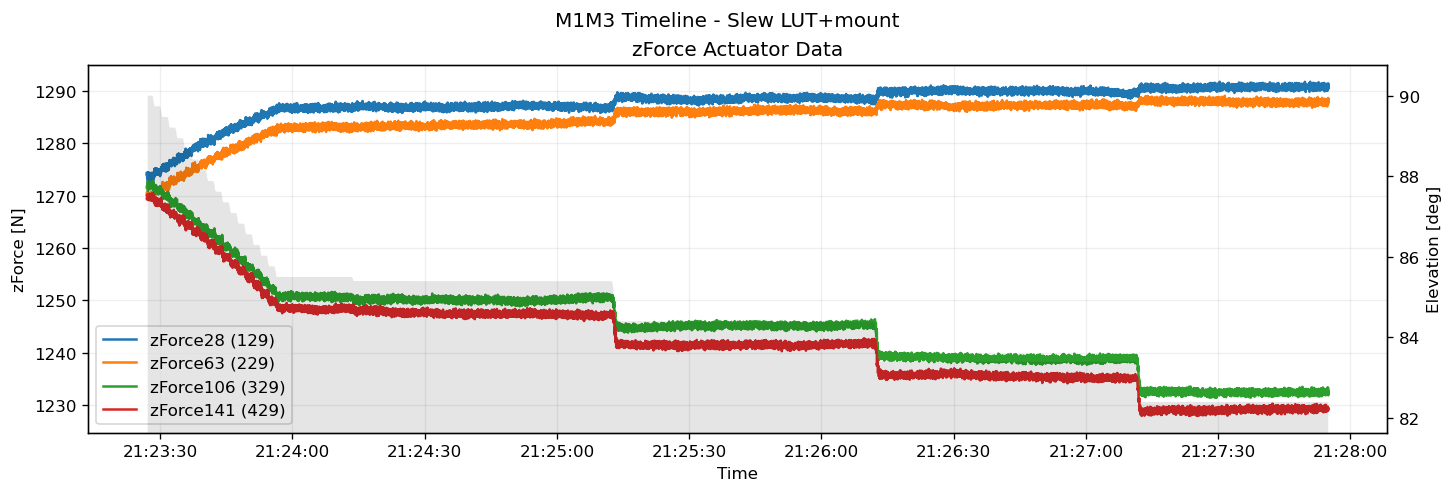

In [24]:
fad = await client.select_time_series(
    "lsst.sal.MTM1M3.forceActuatorData", 
    "*", 
    t_start,
    t_end)

el = await client.select_time_series(
    "lsst.sal.MTMount.elevation",
    "*", 
    t_start,
    t_end)

fig, axs = plt.subplot_mosaic(
    mosaic="A",
    num="Slew Without Correction", 
    constrained_layout=True,
    dpi=120,
    figsize=(12, 4),
)

fig.suptitle("M1M3 Timeline - Slew LUT+mount")
_ = vandv.m1m3.timeline_zforces(axs["A"], fad, "zForce", elevation=el)

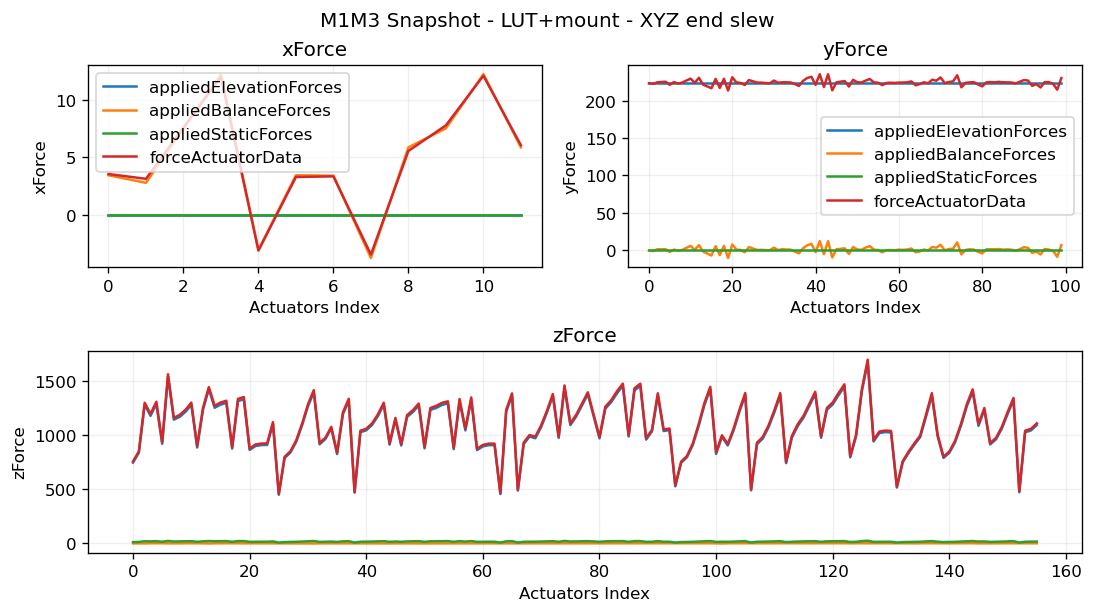

In [25]:
fel = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_appliedElevationForces", 
    "*", 
    t_start,
    t_end)

fba = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_appliedBalanceForces", 
    "*",
    t_start,
    t_end)

fst = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_appliedStaticForces",
    "*",
    t_start,
    t_end)

fao = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_appliedActiveOpticForces",
    "*", 
    t_start,
    t_end)

series = [df.iloc[-1] for df in [fel, fba, fst, fad]]
labels = [
    "appliedElevationForces", 
    "appliedBalanceForces", 
    "appliedStaticForces",
    "forceActuatorData",
]

fig, axs = plt.subplot_mosaic(
    mosaic="AB\nAB\nCC\nCC",
    num="Slew Without Correction - Snapshot Forces", 
    constrained_layout=True,
    dpi=120,
    figsize=(9, 5),
)

fig.suptitle("M1M3 Snapshot - LUT+mount - XYZ end slew")
_ = vandv.m1m3.snapshot_xforces(axs["A"], series, labels=labels)
_ = vandv.m1m3.snapshot_yforces(axs["B"], series, labels=labels)
_ = vandv.m1m3.snapshot_zforces(axs["C"], series)

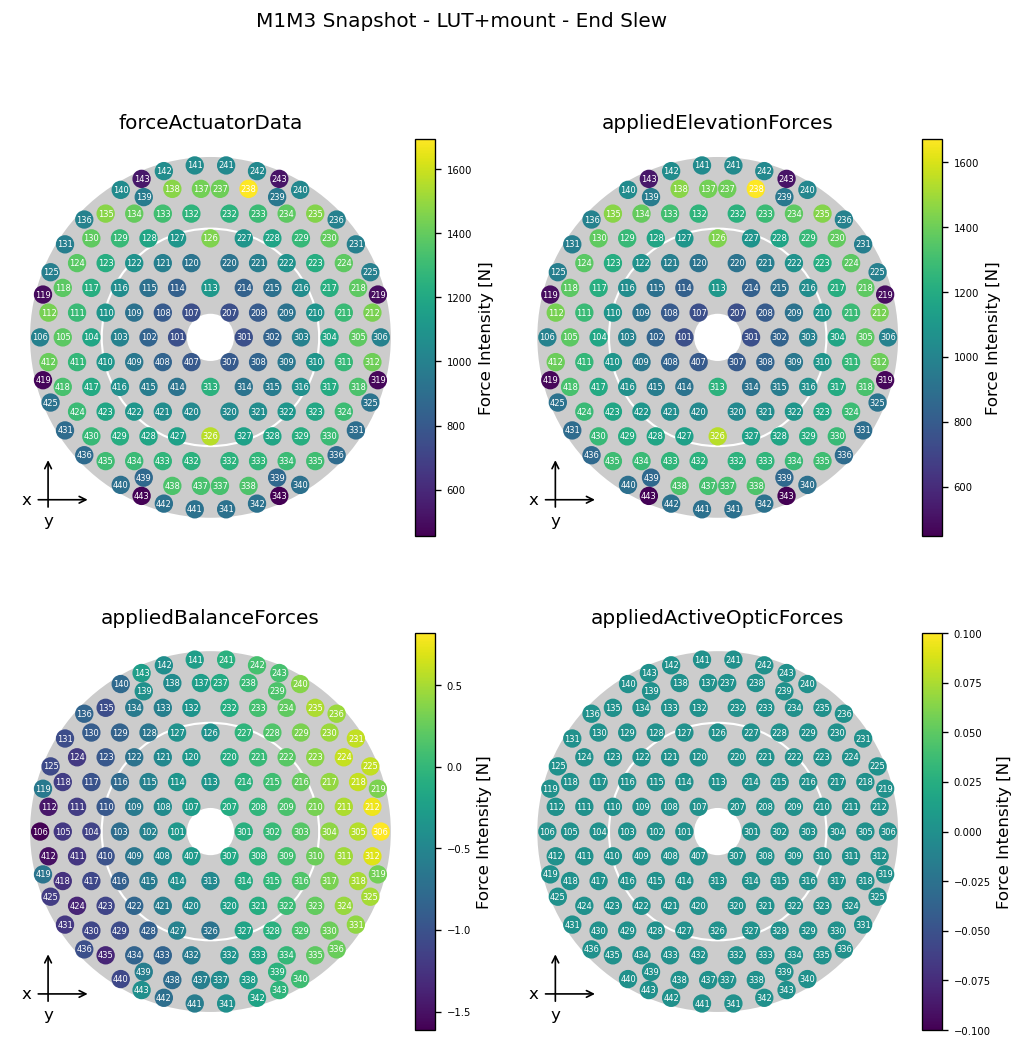

In [26]:
fig, axs = plt.subplot_mosaic(
    mosaic="AB\nCD",
    num="Slew Without Correction - Snapshot zForces Overview", 
    constrained_layout=False,
    dpi=120,
    figsize=(10, 10),
)

fig.suptitle("M1M3 Snapshot - LUT+mount - End Slew")
_ = vandv.m1m3.snapshot_zforces_overview(axs["A"], fad.iloc[-1], title="forceActuatorData")
_ = vandv.m1m3.snapshot_zforces_overview(axs["B"], fel.iloc[-1], title="appliedElevationForces")
_ = vandv.m1m3.snapshot_zforces_overview(axs["C"], fba.iloc[-1], title="appliedBalanceForces")
_ = vandv.m1m3.snapshot_zforces_overview(axs["D"], fao.iloc[-1], title="appliedActiveOpticForces")

### Analyse M2

In [27]:
axf = await client.select_time_series(
    "lsst.sal.MTM2.axialForce", 
    "*",
    t_start,
    t_end)

taf = await client.select_time_series(
    "lsst.sal.MTM2.tangentForce", 
    "*",
    t_start,
    t_end)

cof = await client.select_time_series(
    "lsst.sal.MTM2.command_applyForces",
    "*", 
    t_start,
    t_end)

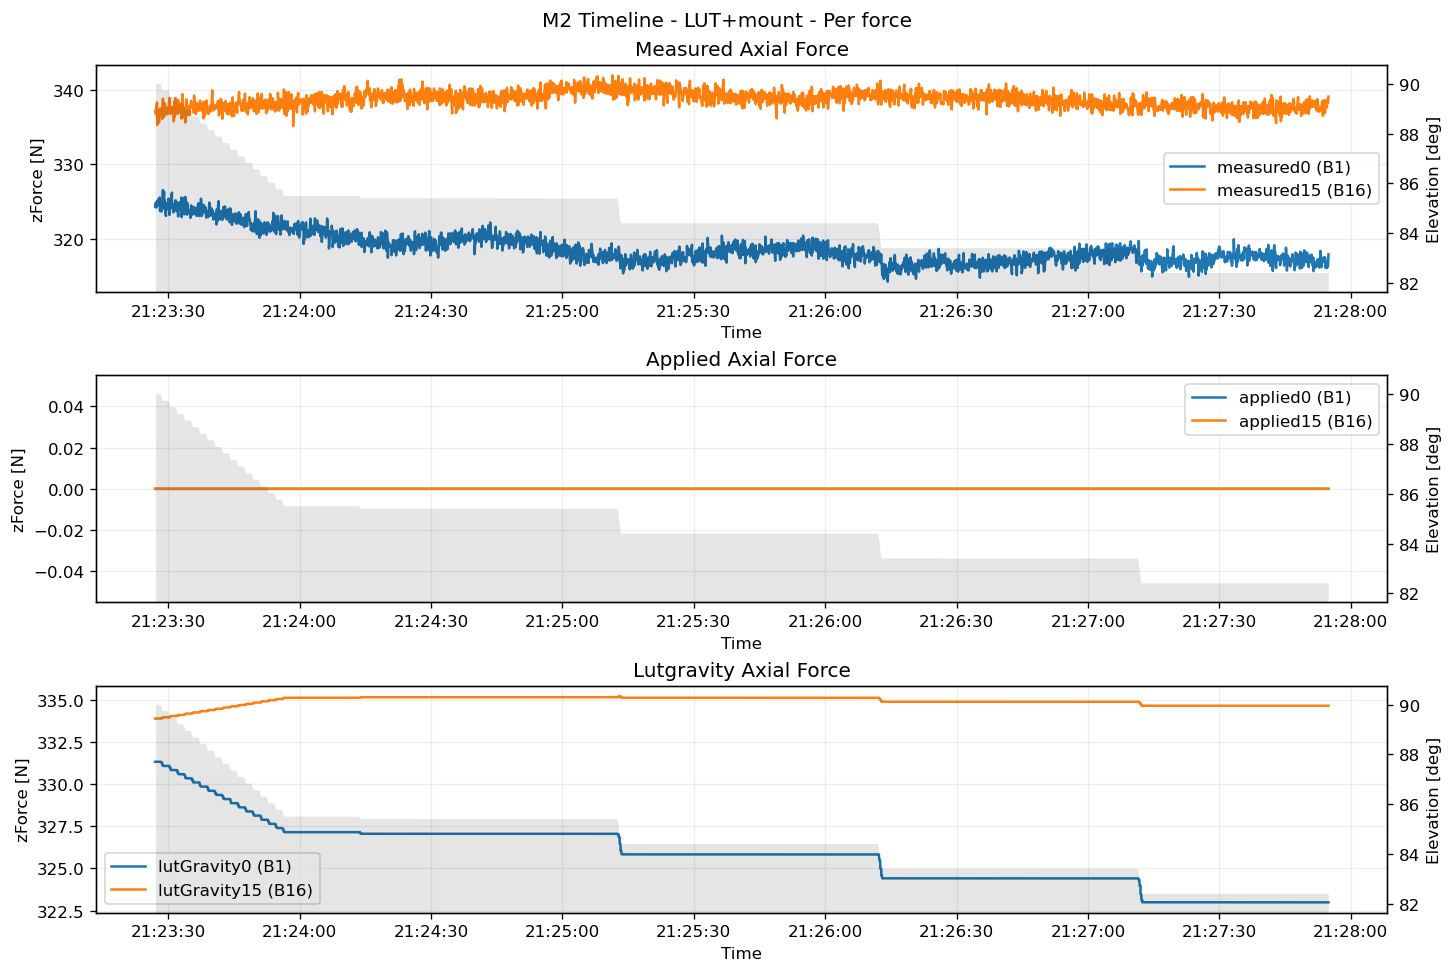

In [28]:
fig, axs = plt.subplot_mosaic(
    mosaic="A\nB\nC",
    num="Slew Without Correction - M2", 
    constrained_layout=True,
    dpi=120,
    figsize=(12, 8),
)

fig.suptitle("M2 Timeline - LUT+mount - Per force")
_ = vandv.m2.timeline_axial_forces(axs["A"], axf, elevation=el)
_ = vandv.m2.timeline_axial_forces(axs["B"], axf, elevation=el, column="applied")
_ = vandv.m2.timeline_axial_forces(axs["C"], axf, elevation=el, column="lutGravity")

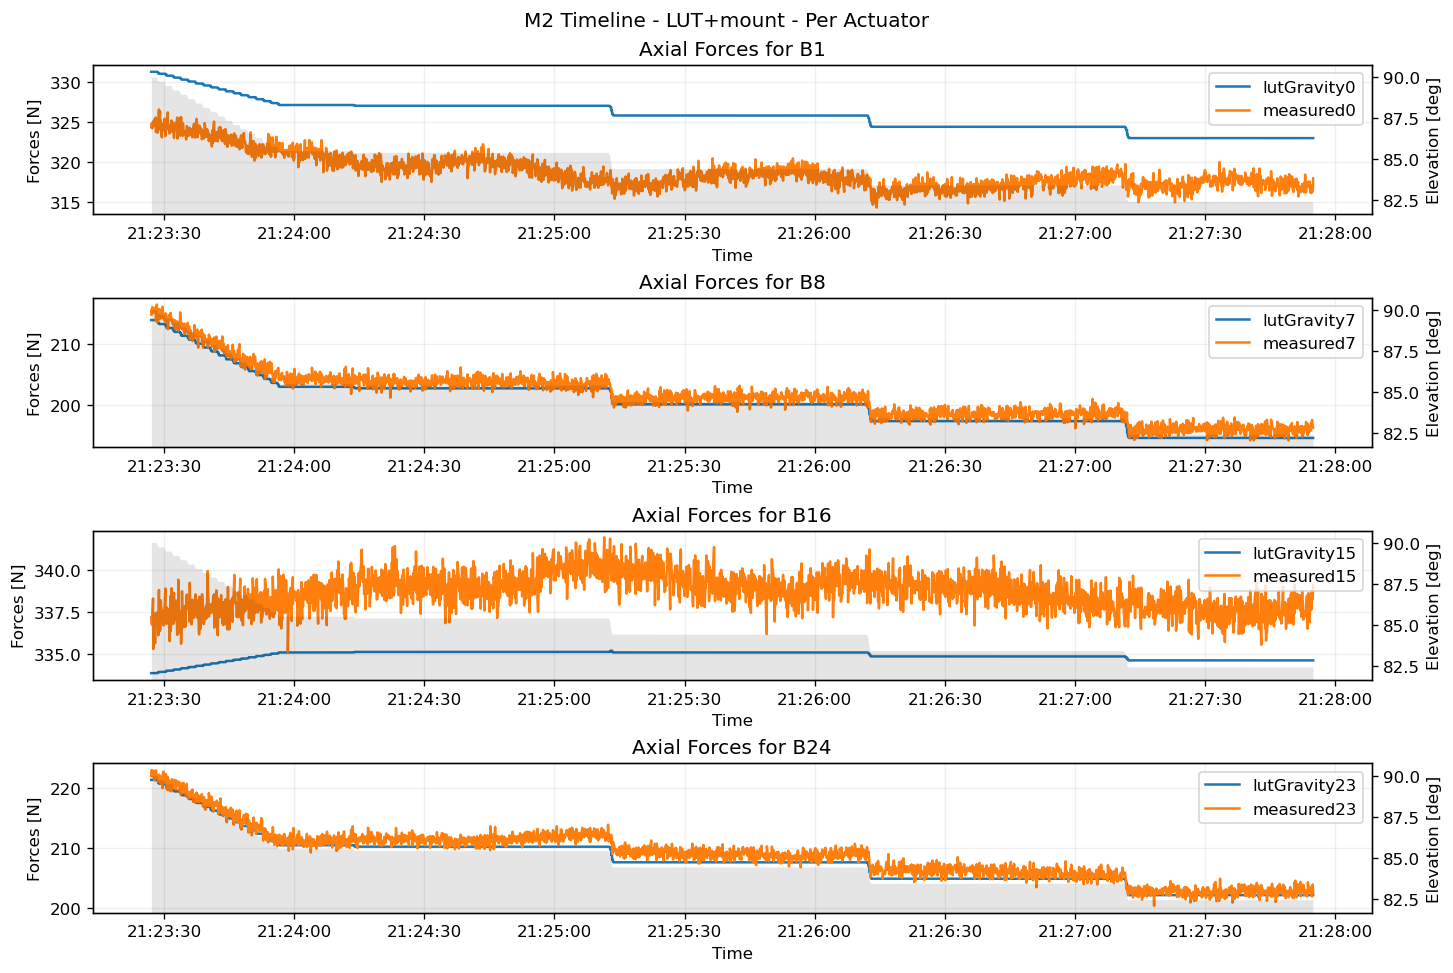

In [29]:
fig, axs = plt.subplot_mosaic(
    mosaic="A\nB\nC\nD",
    num="Slew Without Correction - M2", 
    constrained_layout=True,
    dpi=120,
    figsize=(12, 8),
)

cols = [
    # "applied", 
    # "hardpointCorrection", 
    "lutGravity", 
    # "lutTemperature", 
    "measured"
]

fig.suptitle("M2 Timeline - LUT+mount - Per Actuator")
_ = vandv.m2.timeline_axial_forces_per_act(axs["A"], axf, elevation=el, act="B1", cols=cols)
_ = vandv.m2.timeline_axial_forces_per_act(axs["B"], axf, elevation=el, act="B8", cols=cols)
_ = vandv.m2.timeline_axial_forces_per_act(axs["C"], axf, elevation=el, act="B16", cols=cols)
_ = vandv.m2.timeline_axial_forces_per_act(axs["D"], axf, elevation=el, act="B24", cols=cols)

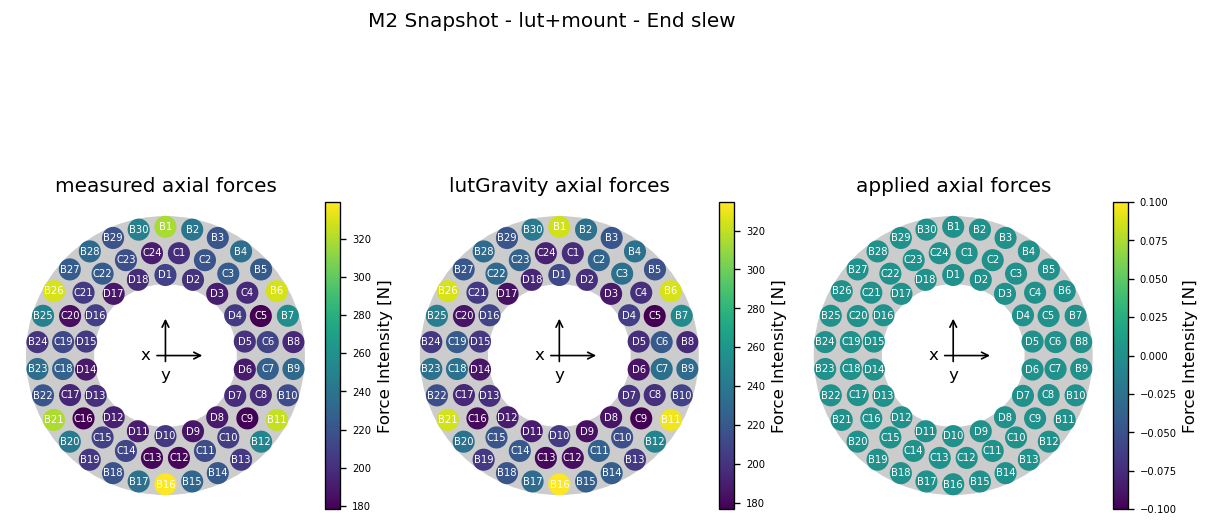

In [30]:
fig, axs = plt.subplot_mosaic(
    mosaic="ABC",
    num="Slew Without Correction - M2 All Actuators", 
    constrained_layout=False,
    dpi=120,
    figsize=(12, 6),
)

fig.suptitle("M2 Snapshot - lut+mount - End slew")
_ = vandv.m2.snapshot_zforces_overview(axs["A"], axf.iloc[-1], ms=150, fs=6)
_ = vandv.m2.snapshot_zforces_overview(axs["B"], axf.iloc[-1], prefix="lutGravity", ms=150, fs=6)
_ = vandv.m2.snapshot_zforces_overview(axs["C"], axf.iloc[-1], prefix="applied", ms=150, fs=6)

### Analyse CamHex

In [31]:
# From the XML:
#   Actual MTHexapod position, in order (X, Y, Z, U, V, W). 
#   Linear positions are in microns, angular positions are in degrees.
pos = await client.select_time_series(
    "lsst.sal.MTHexapod.application",
    "*",
    t_start,
    t_end,
    index=1
)

# Unravel in x/y/z/u/v/w
for i, col in enumerate("xyzuvw"):
    pos[col] = pos[f"position{i}"]


# Triggered at the end of a slew
cpos = await client.select_time_series(
    "lsst.sal.MTHexapod.logevent_compensatedPosition",
    "*",
    t_start,
    t_end,
    index=1
)

# Triggered only after move/offset. Should not see much. 
upos = await client.select_time_series(
    "lsst.sal.MTHexapod.logevent_uncompensatedPosition",
    "*",
    t_start,
    t_end,
    index=1
)

# Estimate the LUT position
lut_pred = vandv.hexapod.get_lut_positions(index=1, elevation=el.actualPosition)
lut = pd.DataFrame(lut_pred, columns=["x", "y", "z", "u", "v", "w"], index=el.index)

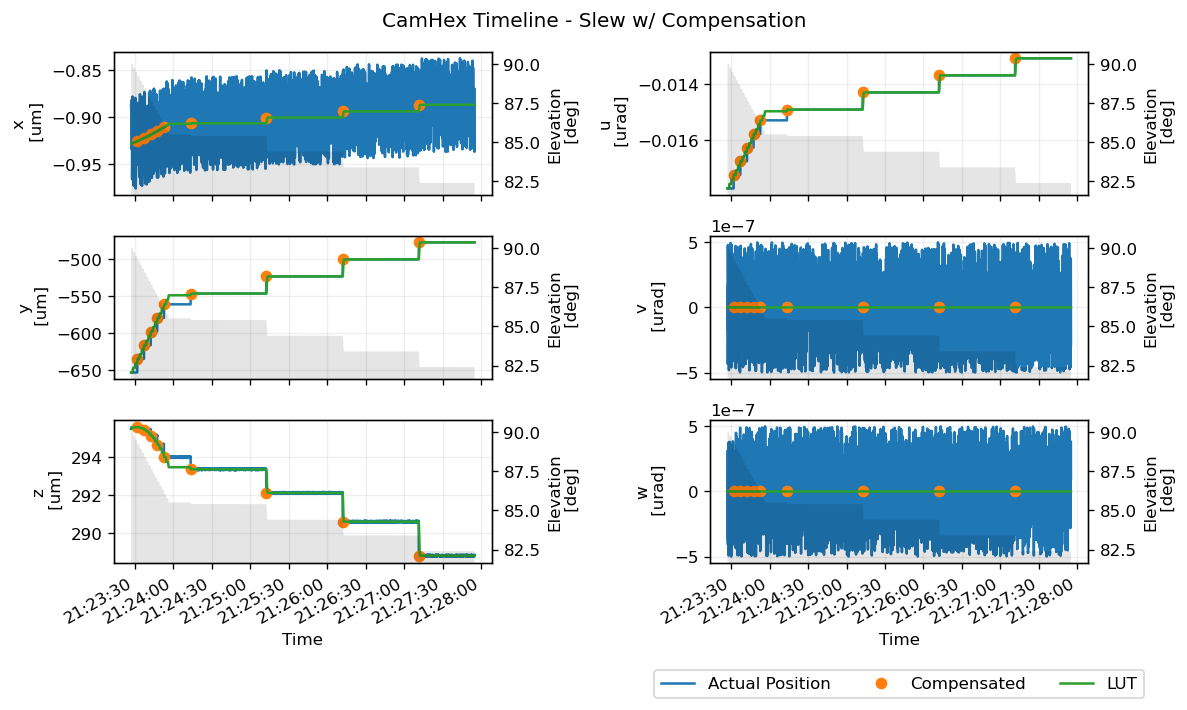

In [32]:
fig, axs = plt.subplot_mosaic(
    mosaic="AD\nBE\nCF",
    num="Slew With LUT Correction - CamHex Actual Position", 
    dpi=120,
    figsize=(10, 6),
    sharex=True,
)

cols = "xyzuvw"
for ax, col in zip("ABCDEF", cols):
    _ = vandv.hexapod.timeline_position(
        axs[ax], 
        [pos, cpos, upos, lut], 
        column=col, 
        elevation=el, 
        symbols=["", "o", "s", ""],
        names=["Actual Position", "Compensated", "Uncompensated", "LUT"]
    )

# Hide xlabel
for i in "ABDE":
    _ = axs[i].set_xlabel("")
    
_ = axs["F"].legend(loc='lower center', bbox_to_anchor=(0.5, -1.0), ncol=5)

fig.suptitle("CamHex Timeline - Slew w/ Compensation")
fig.autofmt_xdate()
fig.tight_layout()

### Analyse M2Hex

In [33]:
# From the XML:
#   Actual MTHexapod position, in order (X, Y, Z, U, V, W). 
#   Linear positions are in microns, angular positions are in degrees.
pos = await client.select_time_series(
    "lsst.sal.MTHexapod.application",
    "*",
    t_start,
    t_end,
    index=2
)

# Unravel in x/y/z/u/v/w
for i, col in enumerate("xyzuvw"):
    pos[col] = pos[f"position{i}"]


# Triggered at the end of a slew
cpos = await client.select_time_series(
    "lsst.sal.MTHexapod.logevent_compensatedPosition",
    "*",
    t_start,
    t_end,
    index=2
)

# Triggered only after move/offset. Should not see much. 
upos = await client.select_time_series(
    "lsst.sal.MTHexapod.logevent_uncompensatedPosition",
    "*",
    t_start,
    t_end,
    index=2
)

# Estimate the LUT position
lut_pred = vandv.hexapod.get_lut_positions(index=2, elevation=el.actualPosition)
lut = pd.DataFrame(lut_pred, columns=["x", "y", "z", "u", "v", "w"], index=el.index)

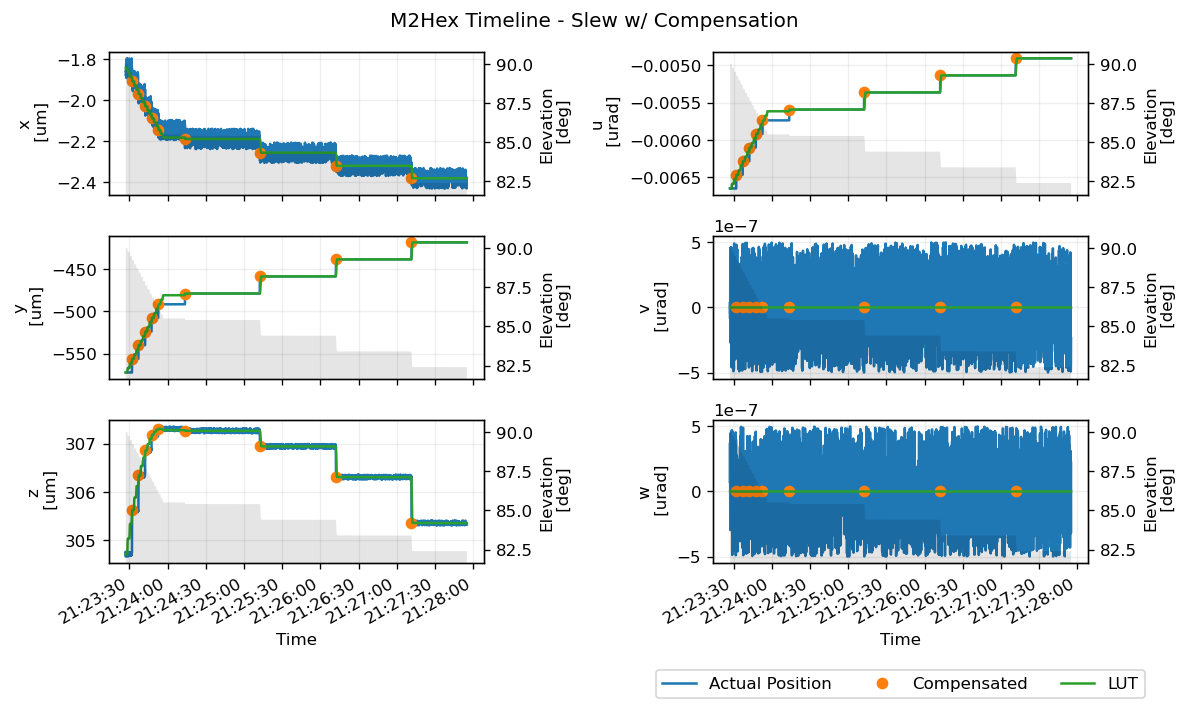

In [34]:
fig, axs = plt.subplot_mosaic(
    mosaic="AD\nBE\nCF",
    num="Slew Without LUT Correction - M2Hex Actual Position", 
    dpi=120,
    figsize=(10, 6),
    sharex=True,
)

cols = "xyzuvw"
for ax, col in zip("ABCDEF", cols):
    _ = vandv.hexapod.timeline_position(
        axs[ax], 
        [pos, cpos, upos, lut], 
        column=col, 
        elevation=el, 
        symbols=["", "o", "s", ""],
        names=["Actual Position", "Compensated", "Uncompensated", "LUT"]
    )

# Hide xlabel
for i in "ABDE":
    _ = axs[i].set_xlabel("")
    
_ = axs["F"].legend(loc='lower center', bbox_to_anchor=(0.5, -1), ncol=5)

fig.suptitle("M2Hex Timeline - Slew w/ Compensation")
fig.autofmt_xdate()
fig.tight_layout()

## Compare Snapshots with LUT

Compare the average snapshots in different elevations using the LUT.

In [35]:
el = await client.select_time_series(
    "lsst.sal.MTMount.elevation",
    "*", 
    t_start,
    t_end)

# Elevation is 85.4 deg
el85 = el[np.isclose(el.actualPosition, 85.4)]
t_start85 = el85.index[0]
t_end85 = el85.index[-1]

# Elevation is 84.4 deg
el84 = el[np.isclose(el.actualPosition, 84.4)]
t_start84 = el84.index[0]
t_end84 = el84.index[-1]

### Analyse M1M3

/tmp/ipykernel_15535/3185875474.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  series = [df.loc[t_start85:t_end85].mean() - df.loc[t_start84:t_end84].mean() for df in [fel, fba, fst, fad]]


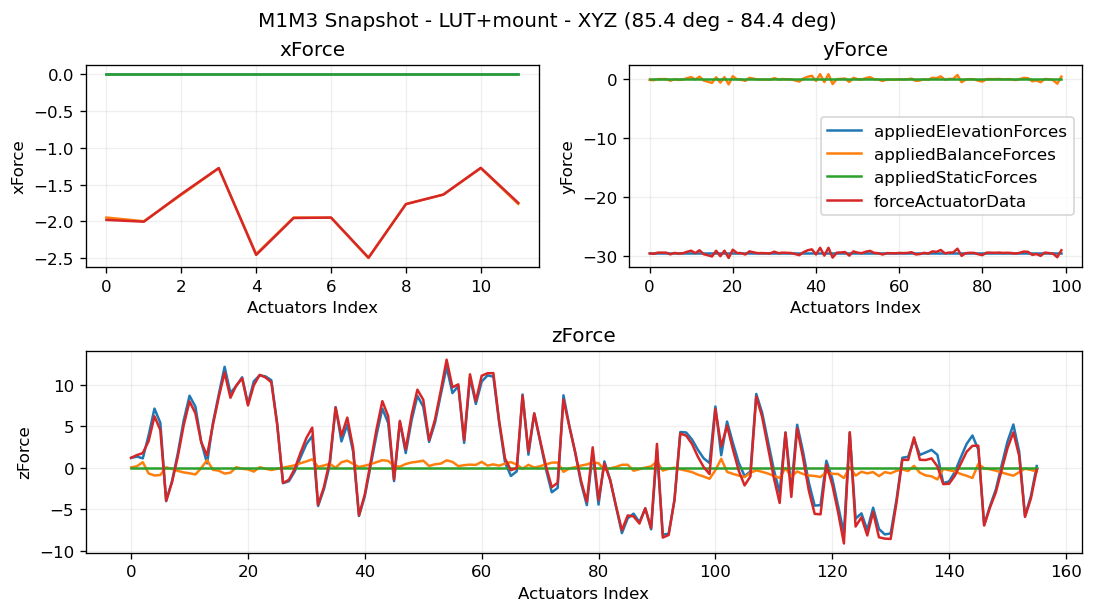

In [36]:
series = [df.loc[t_start85:t_end85].mean() - df.loc[t_start84:t_end84].mean() for df in [fel, fba, fst, fad]]

labels = [
    "appliedElevationForces", 
    "appliedBalanceForces", 
    "appliedStaticForces",
    "forceActuatorData",
]

fig, axs = plt.subplot_mosaic(
    mosaic="AB\nAB\nCC\nCC",
    num="Slew Without Correction - Snapshot Force Differences - 85.4 and 84.4", 
    constrained_layout=True,
    dpi=120,
    figsize=(9, 5),
)

fig.suptitle("M1M3 Snapshot - LUT+mount - XYZ (85.4 deg - 84.4 deg)")
_ = vandv.m1m3.snapshot_xforces(axs["A"], series)
_ = vandv.m1m3.snapshot_yforces(axs["B"], series, labels=labels)
_ = vandv.m1m3.snapshot_zforces(axs["C"], series)

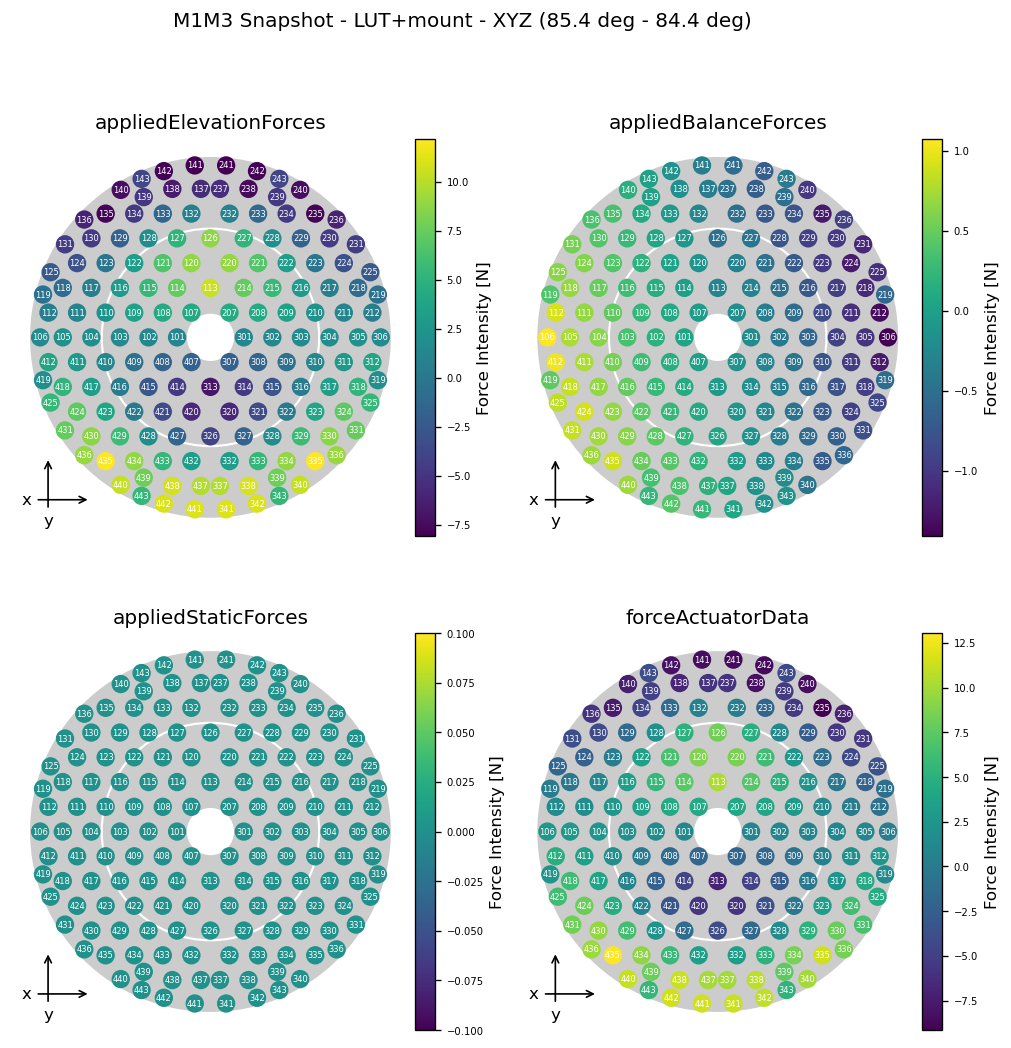

In [37]:
fig, axs = plt.subplot_mosaic(
    mosaic="AB\nCD",
    num="Slew Without Correction - Snapshot zForces Overview - diff(85.4, 84.4)", 
    constrained_layout=False,
    dpi=120,
    figsize=(10, 10),
)

fig.suptitle("M1M3 Snapshot - LUT+mount - XYZ (85.4 deg - 84.4 deg)")
for ax, s, label in zip("ABCD", series, labels):
    _ = vandv.m1m3.snapshot_zforces_overview(axs[ax], s, title=label)

### Analyse M2

/tmp/ipykernel_15535/1301098639.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  m2series = axf.loc[t_start85:t_end85].mean() - axf.loc[t_start84:t_end84].mean()


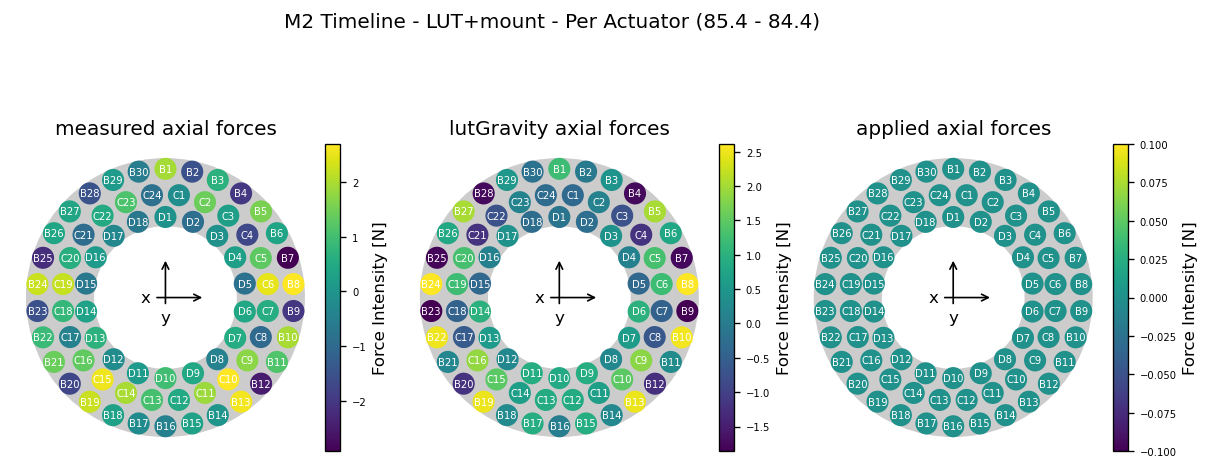

In [38]:
m2series = axf.loc[t_start85:t_end85].mean() - axf.loc[t_start84:t_end84].mean()

fig, axs = plt.subplot_mosaic(
    mosaic="ABC",
    num="M2 Timeline - LUT+mount - Per Actuator (85.4 - 84.4)", 
    constrained_layout=False,
    dpi=120,
    figsize=(12, 5),
)

fig.suptitle("M2 Timeline - LUT+mount - Per Actuator (85.4 - 84.4)")
_ = vandv.m2.snapshot_zforces_overview(axs["A"], m2series, ms=150, fs=6)
_ = vandv.m2.snapshot_zforces_overview(axs["B"], m2series, prefix="lutGravity", ms=150, fs=6)
_ = vandv.m2.snapshot_zforces_overview(axs["C"], m2series, prefix="applied", ms=150, fs=6)